In [5]:
import os
import sys
import subprocess as subp
import json
import numpy as np
from scipy import stats, integrate
import scipy.io as sio
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor, as_completed
import nibabel as nib
from IPython.display import HTML

In [6]:
import collections
import multiprocessing 
import datetime

In [7]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython
sns.set(color_codes=True)

In [8]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [9]:
#custom function for key sorting element
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [10]:
# Set path 
#path_root = '/home/yassinebha/data/data_disk/Drive/HCP2/Solar_heritability/HCP_subtype/'
path_pheno = '/mnt/home_sq/yassinebha/data/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/pheno/'
path_root = '/scratch/yassinebha/pleio/pleio_association/'
# Set file pattern
pedig_file_ptrn = 'solar_{}_spm_pedigre.csv'
pheno_file_ptrn = 'solar_{}_spm_{}_pheno.csv'
pheno_clust = os.path.join(path_pheno,'hcp_pleio_RhoP_pheno_nonan_norm_python_13.csv')
#pheno_clust = os.path.join(path_root,'hcp_bootstraped_pheno_nonan_norm_python_13.csv')
# Set task and trials
task_name = 'emotion'
nb_sbt= 5
list_sbt = ['sub%s' % str(i+1) for i in range(nb_sbt)]
list_trial = ['contrast_fear_vs_neut']

In [11]:
list_sbt

['sub1', 'sub2', 'sub3', 'sub4', 'sub5']

In [12]:
# Load pedig file
pedig_df = pd.read_csv(os.path.join(path_root,pedig_file_ptrn.format(str.upper(task_name))))

In [13]:
# Load subtypes weights
sbt_weight_df = pd.read_csv(os.path.join(path_root,'solar_{}_spm_{}_pheno.csv'.format(str.upper(task_name),
                                                                                 str(nb_sbt))))
sbt_weight_df.count()

ID                                774
EMO_contrast_fear_vs_neut_sub1    774
EMO_contrast_fear_vs_neut_sub2    774
EMO_contrast_fear_vs_neut_sub3    774
EMO_contrast_fear_vs_neut_sub4    774
EMO_contrast_fear_vs_neut_sub5    774
Age_in_Yrs                        774
Gender                            774
BMI                               774
EMO_FD_mean                       774
EMO_FD_scrubbed_mean              774
dtype: int64

In [14]:
# Load phenotype clustered file
#pheno_clust_df = pd.read_csv(pheno_clust).rename(columns={'Subject': 'ID'})
pheno_clust_df = pd.read_csv(pheno_clust)
#pheno_clust_df.loc[:,'ID'] = 'HCP' + pheno_clust_df['ID'].astype(str)
pheno_clust_df.head()

,ID,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13
0,HCP100004,0.466965,0.085162,0.398510,1.185358,-1.530547,-1.051773,0.290558,-0.151578,-0.649200,-0.538317,0.257666,0.252343,-0.279920
1,HCP100206,0.706008,1.436342,1.975280,1.283574,-0.510366,-1.143145,0.556350,0.055734,0.084439,1.301892,-0.077159,0.091172,0.052662
2,HCP100307,-0.559144,-0.713226,-0.703027,0.522789,-0.140952,-0.528705,-0.119682,0.195018,-0.384303,0.492726,0.136348,-0.662889,-0.952467
3,HCP100408,-0.109229,-0.034026,-0.589268,0.092160,0.221359,-0.237051,-1.626095,-0.133106,0.927576,0.018709,0.176793,1.069077,-0.521888
4,HCP100610,-0.575076,-0.386394,0.203063,-0.361182,-0.197974,2.017489,0.519531,0.582089,1.141519,0.894110,0.202821,0.812544,-0.881930


In [15]:
# Clusters list
list_pheno_clust = [x for x in pheno_clust_df.columns.get_values() if x!='ID']
list_pheno_clust

['Cluster_1',
 'Cluster_2',
 'Cluster_3',
 'Cluster_4',
 'Cluster_5',
 'Cluster_6',
 'Cluster_7',
 'Cluster_8',
 'Cluster_9',
 'Cluster_10',
 'Cluster_11',
 'Cluster_12',
 'Cluster_13']

In [16]:
# Merge pheno clusters with subtypes
sbt_pheno_df = pd.merge(sbt_weight_df,pheno_clust_df,how='left',on='ID')
sbt_pheno_df

,ID,EMO_contrast_fear_vs_neut_sub1,EMO_contrast_fear_vs_neut_sub2,EMO_contrast_fear_vs_neut_sub3,EMO_contrast_fear_vs_neut_sub4,EMO_contrast_fear_vs_neut_sub5,Age_in_Yrs,Gender,BMI,EMO_FD_mean,...,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13
0,HCP100206,-0.228,0.027,0.175,0.152,-0.016,27.0,1.0,26.64,0.085915,...,1.283574,-0.510366,-1.143145,0.556350,0.055734,0.084439,1.301892,-0.077159,0.091172,0.052662
1,HCP100307,0.458,-0.186,-0.551,-0.372,0.310,27.0,2.0,22.96,0.096246,...,0.522789,-0.140952,-0.528705,-0.119682,0.195018,-0.384303,0.492726,0.136348,-0.662889,-0.952467
2,HCP100408,-0.534,0.098,0.587,0.464,-0.258,33.0,1.0,27.75,0.123730,...,0.092160,0.221359,-0.237051,-1.626095,-0.133106,0.927576,0.018709,0.176793,1.069077,-0.521888
3,HCP100610,-0.005,-0.287,-0.163,-0.092,0.340,27.0,1.0,36.91,0.166348,...,-0.361182,-0.197974,2.017489,0.519531,0.582089,1.141519,0.894110,0.202821,0.812544,-0.881930
4,HCP101006,0.033,0.073,0.003,-0.017,-0.067,35.0,2.0,30.27,0.125018,...,0.037740,-0.309221,0.589939,-1.023081,-0.181432,-0.978704,-1.191134,-0.134345,0.443699,0.055531
5,HCP101309,-0.365,-0.137,0.271,0.335,0.046,29.0,1.0,22.20,0.084221,...,-1.054605,0.398342,2.455145,-0.285375,-0.649485,-0.505237,-0.640932,0.171810,-0.487710,-0.307215
6,HCP101410,-0.144,-0.501,-0.118,0.143,0.458,29.0,1.0,24.27,0.158659,...,-0.213178,0.390266,-0.737466,0.621544,-0.951644,-0.138672,-0.286932,-0.565053,0.648836,-0.409235
7,HCP101915,0.047,-0.007,-0.090,-0.056,0.061,35.0,2.0,20.42,0.090265,...,-0.837023,1.175929,1.457978,2.486260,-0.090401,0.567062,-1.096749,0.334204,-0.916300,-0.057703
8,HCP102008,0.207,0.410,-0.051,-0.235,-0.281,24.0,1.0,31.42,0.148090,...,-0.101898,0.656850,-0.890857,0.831068,0.283298,0.278978,0.786314,-0.202248,0.735288,0.151105
9,HCP102311,-0.065,0.148,0.060,-0.054,-0.054,26.0,2.0,26.77,0.104134,...,-0.207765,-0.303679,-0.933912,0.786508,0.077634,0.119155,-0.913237,0.540052,-0.439062,0.836023


In [35]:
# check if any NaN value present
sbt_pheno_df.isnull().values.sum()

0

In [36]:
sbt_pheno_df.count()

ID                                774
EMO_contrast_fear_vs_neut_sub1    774
EMO_contrast_fear_vs_neut_sub2    774
EMO_contrast_fear_vs_neut_sub3    774
EMO_contrast_fear_vs_neut_sub4    774
EMO_contrast_fear_vs_neut_sub5    774
Age_in_Yrs                        774
Gender                            774
BMI                               774
EMO_FD_mean                       774
EMO_FD_scrubbed_mean              774
Cluster_1                         774
Cluster_2                         774
Cluster_3                         774
Cluster_4                         774
Cluster_5                         774
Cluster_6                         774
Cluster_7                         774
Cluster_8                         774
Cluster_9                         774
Cluster_10                        774
Cluster_11                        774
Cluster_12                        774
Cluster_13                        774
dtype: int64

### Pleiothropy estimate:

In [42]:
#initiate empty dictionary
Pleio_Asso = collections.namedtuple('Pleio_Asso', [
    'out_dir',
    'pedig_f',
    'pheno_f',
    'var_1',
    'var_2',
    'covar_1'
])
pleio_asso = []

# pleio root folder
path_pleio = os.path.join(path_root,'pleio_{}_{}'.format(str(datetime.date.today()),
                                                        task_name))
if not os.path.exists(path_pleio):
    os.makedirs(path_pleio)

# create ouput folders and populate RhoG dictionnary
for ix_trial, trial in enumerate(list_trial):
    for ix_clust, clust in enumerate(list_pheno_clust):
        for ix_subt, subt in enumerate(list_sbt):
            print(trial,clust,subt)
            pheno_1 = clust
            pheno_2 = '{}_{}_{}'.format(str.upper(task_name)[:3],trial,subt)
            cov_1 = '{}_FD_scrubbed_mean'.format(str.upper(task_name)[:3])
            
            # output result folder 
            path_pleio_contrast = os.path.join(path_pleio,'{}_{}_{}'.format(trial,clust,subt))
            if not os.path.exists(path_pleio_contrast):
                os.makedirs(path_pleio_contrast)
            
            # copy needed files to output folder
            if not os.path.isfile(os.path.join(path_pleio_contrast,'se_univ_polygen.tcl')):
                subp.run(['cp',os.path.join(path_root,'se_univ_polygen.tcl'),path_pleio_contrast])
            if not os.path.isfile(os.path.join(path_pleio_contrast,'pleio_run.sh')):
                subp.run(['cp',os.path.join(path_root,'pleio_run.sh'),path_pleio_contrast])
        
            # pedegree
            if not os.path.isfile(os.path.join(path_pleio_contrast,pedig_file_ptrn.format(str.upper(task_name)))):
                subp.run(['cp',os.path.join(path_root,pedig_file_ptrn.format(str.upper(task_name))),path_pleio_contrast]) 

            pedig_f = os.path.join(path_pleio_contrast,pedig_file_ptrn.format(str.upper(task_name)))

            # save pheno cov to file
            pheno_f= os.path.join(path_pleio_contrast,'pheno_cov.csv')
            if not os.path.isfile(pheno_f):
                sbt_pheno_df[['ID','Age_in_Yrs','Gender',pheno_1,pheno_2,cov_1]].to_csv(pheno_f,index=False)   

            # collect all pleio contrasts in dictionary
            pleio_asso.append(Pleio_Asso(out_dir = path_pleio_contrast,
                                          pedig_f = pedig_f,
                                          pheno_f = pheno_f,
                                          var_1 = pheno_1,
                                          var_2 = pheno_2,
                                          covar_1 = cov_1)) 

contrast_fear_vs_neut Cluster_1 sub1
contrast_fear_vs_neut Cluster_1 sub2
contrast_fear_vs_neut Cluster_1 sub3
contrast_fear_vs_neut Cluster_1 sub4
contrast_fear_vs_neut Cluster_1 sub5
contrast_fear_vs_neut Cluster_2 sub1
contrast_fear_vs_neut Cluster_2 sub2
contrast_fear_vs_neut Cluster_2 sub3
contrast_fear_vs_neut Cluster_2 sub4
contrast_fear_vs_neut Cluster_2 sub5
contrast_fear_vs_neut Cluster_3 sub1
contrast_fear_vs_neut Cluster_3 sub2
contrast_fear_vs_neut Cluster_3 sub3
contrast_fear_vs_neut Cluster_3 sub4
contrast_fear_vs_neut Cluster_3 sub5
contrast_fear_vs_neut Cluster_4 sub1
contrast_fear_vs_neut Cluster_4 sub2
contrast_fear_vs_neut Cluster_4 sub3
contrast_fear_vs_neut Cluster_4 sub4
contrast_fear_vs_neut Cluster_4 sub5
contrast_fear_vs_neut Cluster_5 sub1
contrast_fear_vs_neut Cluster_5 sub2
contrast_fear_vs_neut Cluster_5 sub3
contrast_fear_vs_neut Cluster_5 sub4
contrast_fear_vs_neut Cluster_5 sub5
contrast_fear_vs_neut Cluster_6 sub1
contrast_fear_vs_neut Cluster_6 sub2
c

In [43]:
def run_pleio(x):
    subp.run(['bash', os.path.join(x.out_dir,'pleio_run.sh'),
              x.out_dir,
              x.pedig_f,
              x.pheno_f,
              x.var_1,
              x.var_2,
              x.covar_1,
             ])
    
    # collect result
    RhoE = ''
    RhoE_pval=''
    RhoG = ''
    RhoG_pval_0 = ''
    RhoG_pval_1 = ''
    results = ''
    
    contrast_name = '{}_{}'.format(x.var_1,x.var_2)
    fp = open(os.path.join(x.out_dir,'solar_pleio.out'))
    for i,line in enumerate(fp):
        if 'CONVERGENCE FAILURE' in line:
            print('{}_{}'.format(x.var1,x.var_2))
            print(line)
            results = {'contrast_name' : contrast_name,'no_converg' : True}
            break
        if 'RhoE is ' in line:
            RhoE = float(line.strip('\n').split(' ')[3])
            RhoE_pval = float(line.strip('\n').split(' ')[-1])
        if 'RhoG is ' in line:
            RhoG = float(line.strip('\n').split(' ')[-1])
            #print(out_dir)
            #print(line.strip('\t ').strip('\n'))
        if 'RhoG different from zero' in line:
            RhoG_pval_0 = float(line.strip('\n').split(' ')[-1])
            #print(line.strip('\t '))
        if 'RhoG different from -1.0' in line:
            RhoG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
        elif 'RhoG different from 1.0' in line:
            RohG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
    return results

In [44]:
# function from http://danshiebler.com/2016-09-14-parallel-progress-bar/
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

def parallel_process(array, function, n_jobs=12, use_kwargs=False, front_num=3):
    """
        A parallel version of the map function with a progress bar. 

        Args:
            array (array-like): An array to iterate over.
            function (function): A python function to apply to the elements of array
            n_jobs (int, default=16): The number of cores to use
            use_kwargs (boolean, default=False): Whether to consider the elements of array as dictionaries of 
                keyword arguments to function 
            front_num (int, default=3): The number of iterations to run serially before kicking off the parallel job. 
                Useful for catching bugs
        Returns:
            [function(array[0]), function(array[1]), ...]
    """
    #We run the first few iterations serially to catch bugs
    if front_num > 0:
        front = [function(**a) if use_kwargs else function(a) for a in array[:front_num]]
    #If we set n_jobs to 1, just run a list comprehension. This is useful for benchmarking and debugging.
    if n_jobs==1:
        return front + [function(**a) if use_kwargs else function(a) for a in tqdm(array[front_num:])]
    #Assemble the workers
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        #Pass the elements of array into function
        if use_kwargs:
            futures = [pool.submit(function, **a) for a in array[front_num:]]
        else:
            futures = [pool.submit(function, a) for a in array[front_num:]]
        kwargs = {
            'total': len(futures),
            'unit': 'it',
            'unit_scale': True,
            'leave': True
        }
        #Print out the progress as tasks complete
        for f in tqdm(as_completed(futures), **kwargs):
            pass
    out = []
    #Get the results from the futures. 
    for i, future in tqdm(enumerate(futures)):
        try:
            out.append(future.result())
        except Exception as e:
            out.append(e)
    return front + out

In [45]:
result = parallel_process(pleio_asso,run_pleio,use_kwargs=False)

100%|██████████| 62.0/62.0 [00:41<00:00, 1.49it/s]
62it [00:00, 130611.17it/s]


In [46]:
#with concurrent.futures.ProcessPoolExecutor() as executor:
#    result = executor.map(run_pleio,pleio_asso)

In [47]:
#pool = multiprocessing.Pool()
#result = pool.map(run_pleio,pleio_asso)

In [21]:
from statsmodels.sandbox.stats import multicomp as smi

def fdr_transf(mat,log10 = True):
    '''compute fdr of a given matrix'''
    
    row = mat.shape[0]
    col = mat.shape[1]
    flatt = mat.flatten()
    # replace 0's by 1
    flatt[flatt == 0] =1
    fdr_2d = smi.multipletests(flatt, alpha=0.05, method='fdr_bh')[1]
    if log10 == True:
        fdr_2d = [-np.log10(ii) for ii in fdr_2d] 
    fdr_3d = np.reshape(fdr_2d,(row,col))
    return fdr_3d

In [40]:
# Cluaters from  correlation
dict_clusters = {'Cluster_1' : 'Self_regul',
                 'Cluster_2' : 'Physio',
                 'Cluster_3' : 'Executive',
                 'Cluster_4' : 'Neg_affec',
                 'Cluster_5' : 'Somatic',
                 'Cluster_6' : 'Speed',
                 'Cluster_7' : 'Desord_ext',
                 'Cluster_8' : 'Fitness',
                 'Cluster_9' : 'Pos_affetc',
                 'Cluster_10' : 'Mem_att_mot',
                 'Cluster_11' : 'Desord_int',
                 'Cluster_12' : 'Sens_mot',
                 'Cluster_13' : 'Fluid_intel'}

In [46]:
# Clusters from RhoP corelation 
dict_clusters = {'Cluster_1' : 'Desord_ext',
                 'Cluster_2' : 'Somatic',
                 'Cluster_3' : 'Desord_int',
                 'Cluster_4' : 'Neg_affec',
                 'Cluster_5' : 'Pos_affetc',
                 'Cluster_6' : 'Self_regul',
                 'Cluster_7' : 'Fluid_intel',
                 'Cluster_8' : 'Mem_att_mot',
                 'Cluster_9' : 'Acade_comp',
                 'Cluster_10' : 'Executive',
                 'Cluster_11' : 'Sens_Emo_Fit',
                 'Cluster_12' : 'Physio',
                 'Cluster_13' : 'Speed'}

In [18]:
trial = 'contrast_fear_vs_neut'

In [19]:
line

NameError: name 'line' is not defined

In [21]:
line.strip('\n').split(' ')[-1]

'0.0113266'

In [46]:
H2r = dict()
fp = open(os.path.join('/scratch/yassinebha/pleio/pleio_association/pleio_2018-08-22_emotion/contrast_fear_vs_neut_Cluster_10_sub1','solar_pleio.out'))
for i,line in enumerate(fp):
    if 'H2r(Cluster_10_norm) is ' in line:
        H2r.update({'{}'.format(trial):{'H2r_{}'.format('Cluster_10'):float(line.strip('\n').split(' ')[3])}})
    if 'H2r(Cluster_10_norm) Std. Error: ' in line:
        H2r['{}'.format(trial)].update({'H2r_{}_std'.format('Cluster_10'):float(line.strip('\n').split(' ')[-1])})

In [44]:
H2r.values()

dict_values([{'H2r_Cluster_1_std': 0.082431, 'H2r_Cluster_1': 0.4364454}])

In [26]:
'H2r_{}'.format(clust):float(line.strip('\n').split(' ')[3])

SyntaxError: invalid syntax (<ipython-input-26-b3631e562c2f>, line 1)

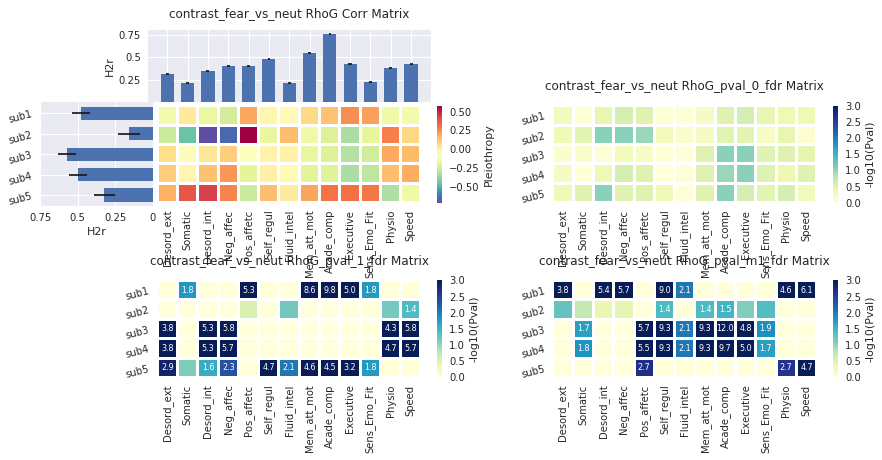

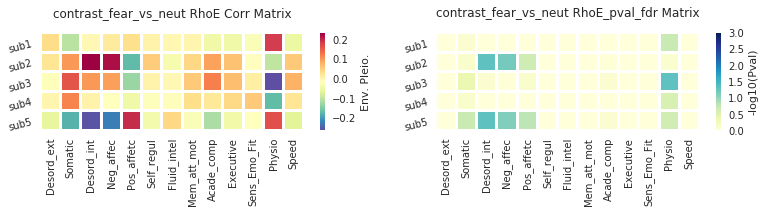

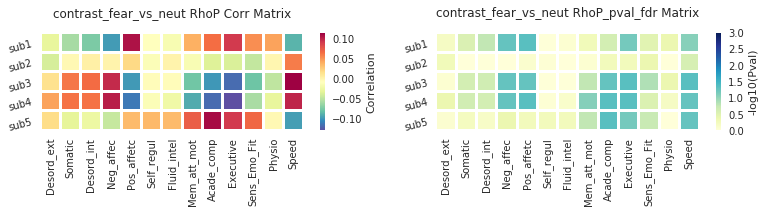

In [68]:
#Initiate no convergence result stack
path_pleio = os.path.join(path_root,'pleio_2018-08-22_emotion')
No_converge = collections.namedtuple('No_converge', ['var_1',
                                                     'var_2',
                                                     'covar_1',
                                                     'pedig_f',
                                                     'pheno_f',
                                                     'out_dir'])
no_converges = []
all_resu = dict()
H2r = dict()
for ix_trial, trial in enumerate(list_trial):
    # initiate empty matrix
    RhoG = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoG_pval_0 = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoG_pval_1 = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoG_pval_m1 = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoE = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoE_pval = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoP = np.zeros((len(list_sbt),len(list_pheno_clust)))
    RhoP_pval = np.zeros((len(list_sbt),len(list_pheno_clust)))
     
    # Loop over cluster
    for ix_clust, clust in enumerate(list_pheno_clust):
        for ix_subt, subt in enumerate(list_sbt):
            
            pheno_1 = clust
            pheno_2 = '{}_{}_{}'.format(str.upper(task_name)[:3],trial,subt)
            cov_1 = '{}_FD_scrubbed_mean'.format(str.upper(task_name))
            
            # output result folder 
            out_dir = os.path.join(path_pleio,'{}_{}_{}'.format(trial,clust,subt))
            pedig_f = os.path.join(out_dir,pedig_file_ptrn.format(str.upper(task_name)))
            
            # pheno cov file
            pheno_f= os.path.join(out_dir,'pheno_cov.csv')
            # pedig file
            pedig_f = os.path.join(out_dir,'pleio_all_pheno_pedig.csv')
            
            #grab results from text file
            fp = open(os.path.join(path_pleio,out_dir,'solar_pleio.out'))
            for i,line in enumerate(fp):
                if 'CONVERGENCE FAILURE' in line:
                    print(out_dir)
                    print(line)
                    count+=1
                    no_converges.append(No_converge(var_1 = pheno_1,
                                                    var_2 = pheno_2,
                                                    covar_1 = cov_1,
                                                    out_dir = out_dir,
                                                    pedig_f = pedig_f,
                                                    pheno_f = pedig_f))
                    break
                    
                    
                if 'H2r({}_norm) is '.format(pheno_1) in line:
                    H2r.update({'{}'.format(pheno_1):{'h2r':float(line.strip('\n').split(' ')[3])}})

                if 'H2r({}_norm) Std. Error: '.format(pheno_1) in line:
                    H2r['{}'.format(pheno_1)].update({'std':float(line.strip('\n').split(' ')[-1])})
                    
                if 'H2r({}_norm) is '.format(pheno_2) in line:
                    H2r.update({'{}'.format(subt):{'h2r':float(line.strip('\n').split(' ')[3])}})

                if 'H2r({}_norm) Std. Error: '.format(pheno_2) in line:
                    H2r['{}'.format(subt)].update({'std':float(line.strip('\n').split(' ')[-1])})

                if 'RhoE is ' in line:
                    RhoE[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[3])
                    RhoE_pval[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                if 'RhoG is ' in line:
                    RhoG[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                    #print(out_dir)
                    #print(line.strip('\t ').strip('\n'))
                if 'RhoG different from zero' in line:
                    RhoG_pval_0[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                    #print(line.strip('\t '))
                if 'RhoG different from -1.0' in line:
                    RhoG_pval_m1[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                elif 'RhoG different from 1.0' in line:
                    RhoG_pval_1[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                if 'RhoP is ' in line:
                    #print(float(line.strip('\n').split(' ')[-1]))
                    RhoP[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    
                if 'RhoP different from zero' in line:
                    RhoP_pval[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                    #print(float(line.strip('\n').split(' ')[-1]))
                    break
    # save matrices
    all_resu.update({'{}'.format(trial):{'RhoE':RhoE,
                                         'RhoE_pval':RhoE_pval,
                                         'RhoE_pval_fdr':fdr_transf(RhoE_pval),
                                         'RhoG':RhoG,
                                         'RhoG_pval_0':RhoG_pval_0,
                                         'RhoG_pval_0_fdr':fdr_transf(RhoG_pval_0),
                                         'RhoG_pval_1':RhoG_pval_1,
                                         'RhoG_pval_1_fdr':fdr_transf(RhoG_pval_1),
                                         'RhoG_pval_m1':RhoG_pval_m1,
                                         'RhoG_pval_m1_fdr':fdr_transf(RhoG_pval_m1),
                                         'RhoP':RhoP,
                                         'RhoP_pval':RhoP_pval,
                                         'RhoP_pval_fdr':fdr_transf(RhoP_pval),
                                         'H2r':H2r,
                                         'list_sbt' :list_sbt,
                                         'list_pheno':list_pheno_clust
                                        }})
    
    ## Plot and save all results

    # RhoG Figure
    f, axes = plt.subplots(2, 2,figsize = (13,5))
    f.subplots_adjust(hspace= .8)

    # Save h2r to csv
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['H2r'])[list_pheno_clust+list_sbt]
    resul_.rename(columns = dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'H2r')))

    # Get H2r of behavioral and subtypes
    h2r_subt_df = resul_[list_sbt] #Subtypes
    h2r_behav_df  = resul_.drop(list_sbt,axis=1) #Behavioral

    # plot subtype H2r horizontal bar plot 
    ax1 =f.add_axes([0,0.6,0.12,0.29])
    y_pos1 = np.arange(len(list_sbt))[::-1]
    ax1.barh(y_pos1,-h2r_subt_df.loc['h2r'],xerr= h2r_subt_df.loc['std'],align ='center',height = 0.65)
    ax1.set_xticks([0,-.25,-.5,-.75,-1])
    ax1.set_xticklabels([0,.25,.5,.75,1])
    ax1.set_xlim(-0.75,0)
    ax1.set_xlabel('H2r')
    ax1.set_yticks(y_pos1)
    ax1.set_yticklabels(list_sbt, rotation=15)

    # plot behavioral H2r horizontal bar plot 
    ax2 =f.add_axes([0.115,0.889,0.302,0.2])
    y_pos2 = np.arange(len(h2r_behav_df.columns.get_values()))
    ax2.bar(y_pos2,h2r_behav_df.loc['h2r'],xerr= h2r_behav_df.loc['std'],align ='center',width =0.65 )
    ax2.set_xticks(y_pos2)
    ax2.set_xticklabels([])
    ax2.set_yticks([0,.25,.5,.75,1])
    ax2.set_yticklabels(['',.25,.5,.75,1])
    ax2.set_ylim(0,0.8)
    ax2.set_ylabel('H2r')


    # save RhoG_pval_0_fdr to csv 
    resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_0_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_p0.rename(columns=dict_clusters,inplace=True)
    resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_0_fdr')))

    # plot RhoG_pval_0_fdr result
    sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[0][1],vmin=0,vmax=3)
    data_p0 = resul_p0.as_matrix()
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[0][1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                         ha='center',va='center', color='w',fontsize=8)
    axes[0][1].set_yticklabels(list_sbt, rotation=15)
    axes[0][1].set_title('{} RhoG_pval_0_fdr Matrix'.format(trial),y=1.1)


    # Save RhoG to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG')))
    # plot RhoG result
    sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Pleiothropy"},linewidths=2,ax=axes[0][0])
    data = resul_.as_matrix()
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[0][0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                         ha='center',va='center', color='w',fontsize=8)
    axes[0][0].set_yticklabels(list_sbt, rotation=15)
    ax2.set_title('{} RhoG Corr Matrix'.format(trial),y=1.1)

    # save RhoG_pval_1_fdr to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_1_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_1_fdr')))
    # plot RhoG_pval_1_fdr result
    sns.heatmap(resul_,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1][0],vmin=0,vmax=3)
    data = resul_.as_matrix()
    for y in range(data.shape[0]):
        for x in range(data.shape[1]): 
            if data[y, x] >= 1.41:
                axes[1][0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                         ha='center',va='center', color='w',fontsize=8)
    axes[1][0].set_yticklabels(list_sbt, rotation=15)
    axes[1][0].set_title('{} RhoG_pval_1_fdr Matrix'.format(trial),y=1.1)

    # save RhoG_pval_m1_fdr to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_m1_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_m1_fdr')))
    # plot RhoG_pval_m1_fdr result
    sns.heatmap(resul_,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1][1],vmin=0,vmax=3)
    data = resul_.as_matrix()
    for y in range(data.shape[0]):
        for x in range(data.shape[1]): 
            if data[y, x] >= 1.41:
                axes[1][1].text(x+0.5, y+.5, '%.1f' % data[y, x],
                         ha='center',va='center', color='w',fontsize=8)
    axes[1][1].set_yticklabels(list_sbt, rotation=15)
    axes[1][1].set_title('{} RhoG_pval_m1_fdr Matrix'.format(trial),y=1.1)

    # Save figure
    f.savefig(os.path.join(path_pleio,'fig_RhoG_{}.svg'.format(trial)))

    # RhoE figure
    f, axes = plt.subplots(1, 2,figsize = (13,1.8))

    # save RhoE_pval_fdr to csv 
    resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE_pval_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_p0.rename(columns=dict_clusters,inplace=True)
    resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoE_pval_fdr')))

    # plot RhoE_pval_fdr result
    sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1],vmin=0,vmax=3)
    data_p0 = resul_p0.as_matrix()
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                             ha='center',va='center', color='w',fontsize=8)
    axes[1].set_yticklabels(list_sbt, rotation=15)
    axes[1].set_title('{} RhoE_pval_fdr Matrix'.format(trial),y=1.1)

    # save RhoE to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoE')))

    # plot RhoE result

    sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Env. Pleio."},linewidths=2,ax=axes[0])
    data = resul_.as_matrix()
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                             ha='center',va='center', color='w',fontsize=8)
    axes[0].set_yticklabels(list_sbt, rotation=15)
    axes[0].set_title('{} RhoE Corr Matrix'.format(trial),y=1.1)


    # Save figure
    f.savefig(os.path.join(path_pleio,'fig_RhoE_{}.svg'.format(trial)))

    # RhoP figure 
    f, axes = plt.subplots(1, 2,figsize = (13,1.8))

    # save RhoP_pval_fdr to csv 
    resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP_pval_fdr'],columns=list_pheno_clust,index=list_sbt)
    resul_p0.rename(columns=dict_clusters,inplace=True)
    resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoP_pval_fdr')))

    # plot RhoP_pval_fdr result
    sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1],vmin=0,vmax=3)
    data_p0 = resul_p0.as_matrix()
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                             ha='center',va='center', color='w',fontsize=8)
    axes[1].set_yticklabels(list_sbt, rotation=15)
    axes[1].set_title('{} RhoP_pval_fdr Matrix'.format(trial),y=1.1)

    # save RhoP to csv 
    resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP'],columns=list_pheno_clust,index=list_sbt)
    resul_.rename(columns=dict_clusters,inplace=True)
    resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoP')))

    # plot RhoP result
    sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Correlation"},linewidths=2,ax=axes[0])
    data = resul_.as_matrix()
    for y in range(data_p0.shape[0]):
        for x in range(data_p0.shape[1]): 
            if data_p0[y, x] >= 1.41:
                axes[0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                             ha='center',va='center', color='w',fontsize=8)
    axes[0].set_yticklabels(list_sbt, rotation=15)
    axes[0].set_title('{} RhoP Corr Matrix'.format(trial),y=1.1)


    # Save figure
    f.savefig(os.path.join(path_pleio,'fig_RhoP_{}.svg'.format(trial)))


# Save all results
np.save(os.path.join(path_pleio,'pleio_all_resuts.npy'),all_resu)

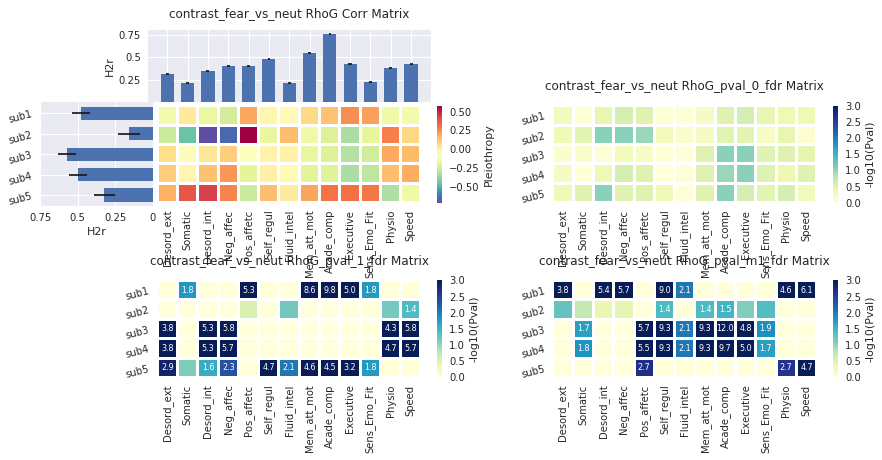

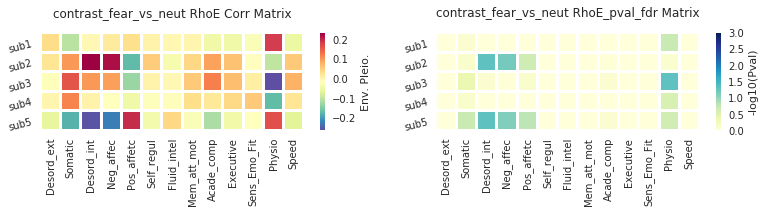

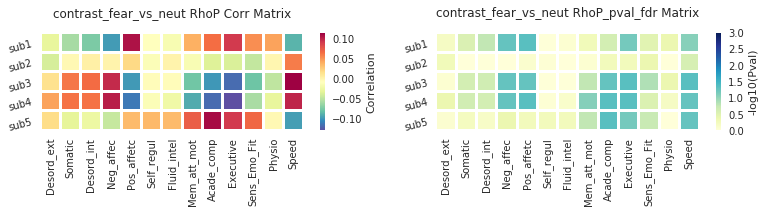

In [67]:
## Plot and save all results

# RhoG Figure
f, axes = plt.subplots(2, 2,figsize = (13,5))
f.subplots_adjust(hspace= .8)

# Save h2r to csv
resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['H2r'])[list_pheno_clust+list_sbt]
resul_.rename(columns = dict_clusters,inplace=True)
resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'H2r')))

# Get H2r of behavioral and subtypes
h2r_subt_df = resul_[list_sbt] #Subtypes
h2r_behav_df  = resul_.drop(list_sbt,axis=1) #Behavioral

# plot subtype H2r horizontal bar plot 
ax1 =f.add_axes([0,0.6,0.12,0.29])
y_pos1 = np.arange(len(list_sbt))[::-1]
ax1.barh(y_pos1,-h2r_subt_df.loc['h2r'],xerr= h2r_subt_df.loc['std'],align ='center',height = 0.65)
ax1.set_xticks([0,-.25,-.5,-.75,-1])
ax1.set_xticklabels([0,.25,.5,.75,1])
ax1.set_xlim(-0.75,0)
ax1.set_xlabel('H2r')
ax1.set_yticks(y_pos1)
ax1.set_yticklabels(list_sbt, rotation=15)

# plot behavioral H2r horizontal bar plot 
ax2 =f.add_axes([0.115,0.889,0.302,0.2])
y_pos2 = np.arange(len(h2r_behav_df.columns.get_values()))
ax2.bar(y_pos2,h2r_behav_df.loc['h2r'],xerr= h2r_behav_df.loc['std'],align ='center',width =0.65 )
ax2.set_xticks(y_pos2)
ax2.set_xticklabels([])
ax2.set_yticks([0,.25,.5,.75,1])
ax2.set_yticklabels(['',.25,.5,.75,1])
ax2.set_ylim(0,0.8)
ax2.set_ylabel('H2r')


# save RhoG_pval_0_fdr to csv 
resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_0_fdr'],columns=list_pheno_clust,index=list_sbt)
resul_p0.rename(columns=dict_clusters,inplace=True)
resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_0_fdr')))

# plot RhoG_pval_0_fdr result
sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[0][1],vmin=0,vmax=3)
data_p0 = resul_p0.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[0][1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                     ha='center',va='center', color='w',fontsize=8)
axes[0][1].set_yticklabels(list_sbt, rotation=15)
axes[0][1].set_title('{} RhoG_pval_0_fdr Matrix'.format(trial),y=1.1)


# Save RhoG to csv 
resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG'],columns=list_pheno_clust,index=list_sbt)
resul_.rename(columns=dict_clusters,inplace=True)
resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG')))
# plot RhoG result
sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Pleiothropy"},linewidths=2,ax=axes[0][0])
data = resul_.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[0][0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                     ha='center',va='center', color='w',fontsize=8)
axes[0][0].set_yticklabels(list_sbt, rotation=15)
ax2.set_title('{} RhoG Corr Matrix'.format(trial),y=1.1)

# save RhoG_pval_1_fdr to csv 
resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_1_fdr'],columns=list_pheno_clust,index=list_sbt)
resul_.rename(columns=dict_clusters,inplace=True)
resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_1_fdr')))
# plot RhoG_pval_1_fdr result
sns.heatmap(resul_,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1][0],vmin=0,vmax=3)
data = resul_.as_matrix()
for y in range(data.shape[0]):
    for x in range(data.shape[1]): 
        if data[y, x] >= 1.41:
            axes[1][0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                     ha='center',va='center', color='w',fontsize=8)
axes[1][0].set_yticklabels(list_sbt, rotation=15)
axes[1][0].set_title('{} RhoG_pval_1_fdr Matrix'.format(trial),y=1.1)

# save RhoG_pval_m1_fdr to csv 
resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_m1_fdr'],columns=list_pheno_clust,index=list_sbt)
resul_.rename(columns=dict_clusters,inplace=True)
resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_m1_fdr')))
# plot RhoG_pval_m1_fdr result
sns.heatmap(resul_,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1][1],vmin=0,vmax=3)
data = resul_.as_matrix()
for y in range(data.shape[0]):
    for x in range(data.shape[1]): 
        if data[y, x] >= 1.41:
            axes[1][1].text(x+0.5, y+.5, '%.1f' % data[y, x],
                     ha='center',va='center', color='w',fontsize=8)
axes[1][1].set_yticklabels(list_sbt, rotation=15)
axes[1][1].set_title('{} RhoG_pval_m1_fdr Matrix'.format(trial),y=1.1)

# Save figure
f.savefig(os.path.join(path_pleio,'fig_RhoG_{}.svg'.format(trial)))

# RhoE figure
f, axes = plt.subplots(1, 2,figsize = (13,1.8))

# save RhoE_pval_fdr to csv 
resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE_pval_fdr'],columns=list_pheno_clust,index=list_sbt)
resul_p0.rename(columns=dict_clusters,inplace=True)
resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoE_pval_fdr')))

# plot RhoE_pval_fdr result
sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1],vmin=0,vmax=3)
data_p0 = resul_p0.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                         ha='center',va='center', color='w',fontsize=8)
axes[1].set_yticklabels(list_sbt, rotation=15)
axes[1].set_title('{} RhoE_pval_fdr Matrix'.format(trial),y=1.1)

# save RhoE to csv 
resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE'],columns=list_pheno_clust,index=list_sbt)
resul_.rename(columns=dict_clusters,inplace=True)
resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoE')))

# plot RhoE result

sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Env. Pleio."},linewidths=2,ax=axes[0])
data = resul_.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                         ha='center',va='center', color='w',fontsize=8)
axes[0].set_yticklabels(list_sbt, rotation=15)
axes[0].set_title('{} RhoE Corr Matrix'.format(trial),y=1.1)


# Save figure
f.savefig(os.path.join(path_pleio,'fig_RhoE_{}.svg'.format(trial)))

# RhoP figure 
f, axes = plt.subplots(1, 2,figsize = (13,1.8))

# save RhoP_pval_fdr to csv 
resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP_pval_fdr'],columns=list_pheno_clust,index=list_sbt)
resul_p0.rename(columns=dict_clusters,inplace=True)
resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoP_pval_fdr')))

# plot RhoP_pval_fdr result
sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1],vmin=0,vmax=3)
data_p0 = resul_p0.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                         ha='center',va='center', color='w',fontsize=8)
axes[1].set_yticklabels(list_sbt, rotation=15)
axes[1].set_title('{} RhoP_pval_fdr Matrix'.format(trial),y=1.1)

# save RhoP to csv 
resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP'],columns=list_pheno_clust,index=list_sbt)
resul_.rename(columns=dict_clusters,inplace=True)
resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoP')))

# plot RhoP result
sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Correlation"},linewidths=2,ax=axes[0])
data = resul_.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                         ha='center',va='center', color='w',fontsize=8)
axes[0].set_yticklabels(list_sbt, rotation=15)
axes[0].set_title('{} RhoP Corr Matrix'.format(trial),y=1.1)


# Save figure
f.savefig(os.path.join(path_pleio,'fig_RhoP_{}.svg'.format(trial)))



In [30]:
list(element for row in show_annot_array for element in row)

[False, True, True, True]

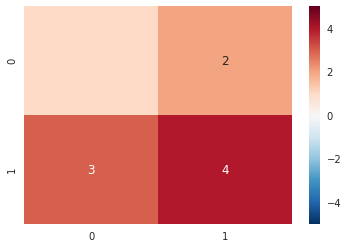

In [23]:
par_corr_p = np.array([[1, 2], [3, 4]])

data = par_corr_p
show_annot_array = data >= 2

fig, ax = plt.subplots()
sns.heatmap(
    ax=ax,
    data=data,
    annot=data,
    cmap ='RdBu_r', center=0, vmin=-5, vmax=5
)
for text, show_annot in zip(ax.texts, (element for row in show_annot_array for element in row)):
    text.set_visible(show_annot)

plt.show()